In [1]:
from helper import *
%matplotlib inline
# set display defaults
#plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
#plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
def select(imgs, n = 3, fold = 10):
    mags = [None] * (len(imgs)/2)
    for i in range(len(imgs)/2):
        mag, _ = cv2.cartToPolar(np.asarray(imgs[2*i], dtype = np.float32), np.asarray(imgs[2*i+1], dtype = np.float32))
        mags[i] = cv2.norm(mag)
    mags = np.asarray(mags)
    mags /= np.sum(mags)
    idx = []
    tmp = np.random.choice(len(mags), fold, replace=False, p = mags)
    for i in range(fold):
        idx.append([max(0, tmp[i]-10), tmp[i], min(tmp[i]+10, len(imgs)/2)])
    return np.asarray(idx)

In [3]:
caffe_root = '/home/bysong/caffe/'
caffe.set_mode_gpu()
# load original model
model_def = './models/caffenet_siamese_cam/deploy.prototxt'
model_weights = './models/caffenet_siamese_cam/caffenet_train_iter_18174.caffemodel'
net = caffe.Net(model_def, model_weights, caffe.TEST) 
                                                                                 
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
#transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR
transformer.set_mean('data', np.ones(3)*np.mean(np.load('./data/mean.npy')))

In [4]:
fold = 5

In [5]:
net.blobs['triple_data'].reshape(fold, 9, 227, 227)

In [6]:
train_list, test_list = load_list('./data', dataset = 1)

In [7]:
#video = 'F_08c8C6AJSVY'
video = train_list[0]

In [8]:
print video

F_aqvxyejK0MQ


In [9]:
reverse = False
flip = False

In [10]:
if (is_forward(video) and (not reverse)) or ((not is_forward(video)) and reverse):
    direction = 'f'
else:
    direction = 'b'

In [11]:
imgs = load_video(video, './data/ArrowDataAll/', mask = lambda x: x[:2] == 'im', grayscale = False, reverse = False, flip = flip)
#imgs = map(lambda x: cv2.resize(x, (227, 227)), imgs)
flows = load_video(video, './data/ArrowDataAll/', mask = lambda x: x[:3] == 'off', grayscale = True, flip = flip, reverse = False)

In [12]:
sel = select(flows, fold = fold)
#sel = [max(sel[0] - 10, 0), sel[0], min(sel[0] + 10, len(imgs)-1)]
#sel = [0, 5, 10]
if reverse:
    sel = sel[::-1]
images = []
for idx in sel:
    img = np.take(imgs, idx, axis = 0)
    img = map(lambda x: transformer.preprocess('data', x), img)
    img = np.asarray(np.concatenate(img, axis = 0))
    images.append(img)
images = np.asarray(images)

In [13]:
net.blobs['triple_data'].data[...] = images

In [14]:
sel[0]

array([ 99, 109, 119])

In [15]:
net.forward()

{'prob': array([[ 0.58994901,  0.41005093],
        [ 0.81570554,  0.18429443],
        [ 0.793042  ,  0.206958  ],
        [ 0.6781801 ,  0.32181996],
        [ 0.14673232,  0.85326773]], dtype=float32)}

In [16]:
print np.sum(net.blobs['prob'].data, axis = 0)
direction = np.sum(net.blobs['prob'].data, axis = 0).argmax()

[ 3.02360916  1.97639108]


## class activation map

### filters

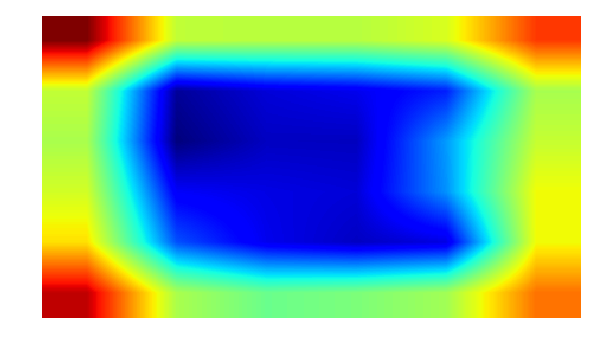

In [38]:
sz = imgs[0].shape[:2]
t = 511
plt.imshow(cv2.resize(net.blobs['conv7'].data[0][t], sz[::-1]))
plt.axis('off')
plt.tight_layout()
plt.savefig('../report/figs/cam/' + video + '-conv7-' + str(t) + '.png')

In [23]:
img[0].shape[:2]

(227, 227)

### CAM

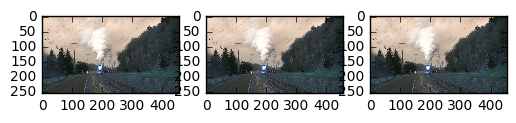

In [244]:
img = np.take(imgs, sel[0], axis = 0)
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(img[i])

In [246]:
direction = 1

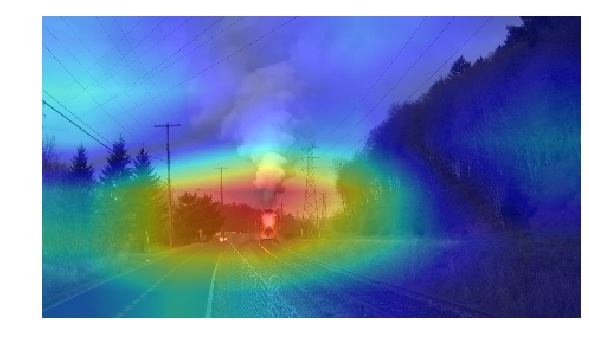

In [248]:
sz = img[0].shape[:2]
n_figs = 1
for i in range(n_figs):
    w = net.params['fc9'][0].data[direction][512*i:512*(i+1)]
    cam = np.zeros(sz)
    for j in range(512):
        if i == 0:
            cam += w[j]*cv2.resize(net.blobs['conv7'].data[0][j], sz[::-1])
        elif i == 1:
            cam += w[j]*cv2.resize(net.blobs['conv7_p'].data[0][j], sz[::-1])
        else:
            cam += w[j]*cv2.resize(net.blobs['conv7_q'].data[0][j], sz[::-1])
    plt.subplot(1,n_figs,i+1)
    plt.imshow(cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB))
    plt.imshow(np.abs(cam), alpha = 0.5)
    plt.axis('off')
plt.tight_layout()
plt.savefig('../report/figs/cam/' + video + '-cam-' + str(n_figs) + '.png')